In [1]:
import tensorflow as tf
import numpy as np
import gym
from gym.spaces import Box, Discrete
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal

In [2]:
"""
Actor-Critics
"""
def mlp(x, hidden_sizes=(32,), activation=tf.tanh, output_activation=None):
    for h in hidden_sizes[:-1]:
        x = tf.layers.dense(x, units=h, activation=activation)
    return tf.layers.dense(x, units=hidden_sizes[-1], activation=output_activation)

def mlp_categorical_policy(x, a, hidden_sizes, act_dim, activation=tf.tanh, output_activation=None):
    logits = mlp(x, list(hidden_sizes)+[act_dim], activation=activation, output_activation=None)
    logp_all = tf.nn.log_softmax(logits, axis=1)
    
    pi = tf.squeeze(tf.multinomial(logits, num_samples=1), axis=1) #不需要归一化
    logp_pi = tf.reduce_sum(tf.one_hot(pi, depth=act_dim) * logp_all, axis=1) #通过tf.one_hot对logp_all进行切片
    logp_a = tf.reduce_sum(tf.one_hot(a, depth=act_dim) * logp_all, axis=1)
    return pi, logp_pi, logp_a

def mlp_gaussian_policy(x, a, hidden_sizes, act_dim, activation=tf.tanh, output_activation=None):
    mu = mlp(x, list(hidden_sizes) + [act_dim], activation=activation, output_activation=output_activation)
    log_std = tf.get_variable(name='log_std', initializer=-0.5*np.ones(act_dim, dtype=np.float32))
    std = tf.exp(log_std)
    
    pi = mu + tf.random_normal(tf.shape(mu)) * std
    logp_pi = log_likelihood(pi, mu, log_std)
    logp_a = log_likelihood(a, mu, log_std)
    return pi, logp_pi, logp_a

EPS = 1e-8

def log_likelihood(x, mu, log_std):
    return tf.reduce_sum(-0.5*(((x-mu)/(tf.exp(log_std)+EPS))**2 + 2*log_std + np.log(2*np.pi)), axis=1)

def actor_critic(x, a, hidden_sizes, act_dim, discrete_act, activation=tf.tanh, output_activation=None):
    actor = mlp_categorical_policy if discrete_act else mlp_gaussian_policy
    
    with tf.variable_scope('pi'):
        pi, logp_pi, logp_a = actor(x, a, hidden_sizes, act_dim, activation, output_activation)
    with tf.variable_scope('v'):
        v = tf.squeeze(mlp(x, list(hidden_sizes)+[1], activation=activation, output_activation=None),axis=1)
        
    return pi,logp_pi,logp_a,v

In [3]:
def discount_cumsum(x, discount):
    """
    magic from rllab for computing discounted cumulative sums of vectors.

    input: 
        vector x, 
        [x0, 
         x1, 
         x2]

    output:
        [x0 + discount * x1 + discount^2 * x2,  
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

class VPGBuffer(object):
    #需要保存多条轨迹数据，作为一个batch，且是用于on-policy策略
    def __init__(self, obs_dim, act_dim, size, act_dtype, discrete_act, gamma=0.99, gae_lam=0.95):
        if (discrete_act):
            self.act_buf = np.zeros(size, dtype=act_dtype)
        else:
            self.act_buf = np.zeros([size, act_dim], dtype=act_dtype)
        
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.val_buf = np.zeros(size, dtype=np.float32)
        self.logp_buf = np.zeros(size, dtype=np.float32)
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.ret_buf = np.zeros(size, dtype=np.float32)
        self.gamma=gamma
        self.gae_lam=gae_lam
        self.ptr, self.start_ptr, self.max_size = 0, 0, size

    def store(self, obs, act, rew, val, logp):
        assert self.ptr<self.max_size
        
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.val_buf[self.ptr] = val
        self.logp_buf[self.ptr] = logp
        self.ptr += 1

    def update_last(self, last_value):
        index=slice(self.start_ptr, self.ptr)
        val = np.append(self.val_buf[index], last_value)
        rew = np.append(self.rew_buf[index], last_value)
        self.ret_buf[index] = discount_cumsum(rew, self.gamma)[:-1]
        
        delta = rew[:-1] + self.gamma*val[1:] - val[:-1]
        self.adv_buf[index] = discount_cumsum(delta, self.gamma * self.gae_lam)

        self.start_ptr = self.ptr

    def statistics_scalar(self, x):
        x = np.array(x, dtype=np.float32).reshape([-1,])
        return np.mean(x), np.std(x)        
        
    def get(self):
        assert self.ptr == self.max_size    # buffer has to be full before you can get
        self.ptr, self.path_start_idx = 0, 0
        
        # the next two lines implement the advantage normalization trick
        adv_mean, adv_std = self.statistics_scalar(self.adv_buf)
        self.adv_buf = (self.adv_buf - adv_mean) / adv_std
        
        return dict(obs=self.obs_buf,
                    act=self.act_buf, 
                    adv=self.adv_buf, 
                    ret=self.ret_buf, 
                    logp=self.logp_buf)

In [4]:
class VPG(object):
    def __init__(self, **kwargs):
        self.init_hyperparameters(**kwargs)
        self.buffer = VPGBuffer(obs_dim=self.obs_dim, act_dim=self.act_dim, 
                                       size=self.hyperparameters['step_per_epoch'],
                                       act_dtype=self.act_dtype, discrete_act=self.discrete_act)
        self.init_algorithm()
        pass
    
    def init_hyperparameters(self, **kwargs):
        self.hyperparameters = dict(env='CartPole-v0', seed=0, epochs=100, step_per_epoch=5000,  
                                   gamma=0.99, gae_lambda=0.8, max_ep_len=1000, act_noise=0.1, lr_pi=1e-3, lr_v=1e-3, epsilon=0.1,
                                   hidden_sizes = (40,))
        
        for param in kwargs:
            self.hyperparameters[param] = kwargs[param]
            
        self.env = gym.make(self.hyperparameters['env'])
        self.discrete_act = True if isinstance(self.env.action_space, Discrete) else False
        
        self.obs_dim = self.env.observation_space.shape[0]
        self.act_dim = self.env.action_space.n if self.discrete_act else self.env.action_space.shape[0]
        
        self.act_dtype = np.int32 if self.discrete_act else np.float32
        self.act_ph_dtype = tf.int32 if self.discrete_act else tf.float32
        
        
        tf.set_random_seed(self.hyperparameters['seed'])
        np.random.seed(self.hyperparameters['seed'])
        self.env.seed(self.hyperparameters['seed'])
        
        self.mean_rew = []
        
    def init_algorithm(self):
        #算法初始化，包括网络初始化
        self.s_ph = tf.placeholder(dtype=tf.float32, shape=[None, self.obs_dim])
        self.a_ph = tf.placeholder(dtype=self.act_ph_dtype, shape=[None,]) if self.discrete_act else tf.placeholder(dtype=self.act_ph_dtype, shape=[None, self.act_dim])
        self.adv_ph = tf.placeholder(dtype=tf.float32, shape=[None,])
        self.ret_ph = tf.placeholder(dtype=tf.float32, shape=[None,])
        
        self.pi, self.logp_pi, self.logp_a, self.v = actor_critic(self.s_ph, self.a_ph, hidden_sizes=self.hyperparameters['hidden_sizes'],
                                               act_dim=self.act_dim, discrete_act=self.discrete_act,
                                               activation=tf.tanh, output_activation=None)

        self.loss_pi = -tf.reduce_mean(self.logp_a * self.adv_ph)
        self.loss_v = tf.reduce_sum(tf.squared_difference(self.ret_ph, self.v))
        
        self.train_loss_pi = tf.train.AdamOptimizer(learning_rate=self.hyperparameters['lr_pi']).minimize(self.loss_pi)
        self.train_loss_v = tf.train.AdamOptimizer(learning_rate=self.hyperparameters['lr_v']).minimize(self.loss_v)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
        self.mean_rew = []
        
    def get_action(self, s):
        a = self.sess.run(self.pi, feed_dict={self.s_ph:s.reshape([1,-1])})[0]
        logp_pi = self.sess.run(self.logp_pi, feed_dict={self.s_ph:s.reshape([1,-1])})[0]
        v = self.sess.run(self.v, feed_dict={self.s_ph:s.reshape([1,-1])})[0]
        return a, logp_pi, v
    
    def run(self):
        for epoch in tqdm(range(self.hyperparameters['epochs'])):
            s, ep_len, sum_r, sum_ep = self.env.reset(), 0, 0, 0
            for step in range(self.hyperparameters['step_per_epoch']):
                a, logp_pi, v = self.get_action(s)
                s_, r, d, _ = self.env.step(a)
                s = s_
                self.buffer.store(s,a,r,v,logp_pi)
                
                ep_len += 1
                sum_r += r
                
                if (d or ep_len == self.hyperparameters['max_ep_len'] or step == self.hyperparameters['step_per_epoch']):
                    last_value = r if d else self.sess.run(self.v, feed_dict={self.s_ph:s.reshape([1,-1])})
                    self.buffer.update_last(last_value)
                    sum_ep += 1
                    s, ep_len = self.env.reset(), 0
            
            self.update()
            self.mean_rew.append(sum_r/(sum_ep+EPS))
        
        '''
        total_steps = self.hyperparameters['epochs'] * self.hyperparameters['step_per_epoch']
        s = self.env.reset()
        sum_rew = 0.0
        sum_epoch = 0.0
        
        n_epoch = 0
        n_episode = 0
        n_step = 0
        for t in tqdm(range(total_steps)):
            a = self.get_action(s)
            s_, r, d, _ = self.env.step(a)
            self.replay_buffer.store(s, a, r, s_, d)
            s = s_
            sum_rew += r
            n_step += 1
            
            if (d or n_step > self.hyperparameters['max_ep_len']):
                sum_epoch += sum_rew
                sum_rew = 0.0
                n_episode += 1
                n_step = 0
                s = self.env.reset()
                
                self.update()
                if (t // self.hyperparameters['step_per_epoch'] > n_epoch):
                    n_epoch+=1
                    self.sess.run(self.target_copy)
                    
                    self.mean_rew.append(sum_epoch/n_episode)
                    sum_epoch = 0
                    n_episode = 0
        '''

    def update(self):
        samples = self.buffer.get()
        feed_dict={self.s_ph:samples['obs'],
                   self.a_ph:samples['act'],
                   self.adv_ph:samples['adv'],
                   self.ret_ph:samples['ret']}
        
        self.sess.run(self.train_loss_pi, feed_dict=feed_dict)
        self.sess.run(self.train_loss_v, feed_dict=feed_dict)
    

    def show_result(self):
        plt.figure()
        plt.plot(np.arange(len(self.mean_rew)), self.mean_rew)       
    

In [5]:
agent = VPG(env='CartPole-v0', epochs=50, hidden_sizes=(64,32))#, step_per_epoch=1000, max_ep_len=500)
#env='CartPole-v0', seed=0, epochs=100, step_per_epoch=5000, replay_size=int(1e6), 
#                                   gamma=0.99, batch_size=100, max_ep_len=1000, act_noise=0.1, lr=1e-3, epsilon=0.1,
#                                   hidden_sizes = (40,)

agent.run()

100%|██████████| 50/50 [02:08<00:00,  2.57s/it]


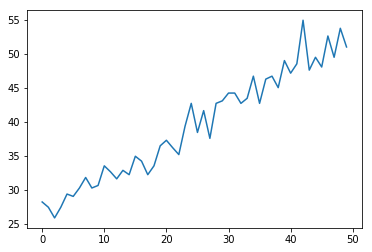

In [6]:
agent.show_result()

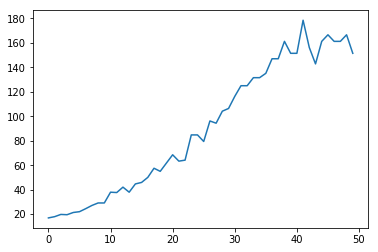

In [6]:
agent.show_result()

100%|██████████| 50/50 [02:34<00:00,  3.09s/it]


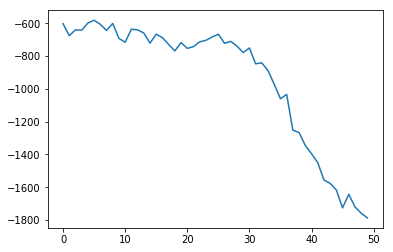

In [5]:
agent2 = VPG(env='HalfCheetah-v2', epochs=50, hidden_sizes=(64,32))#, step_per_epoch=1000, max_ep_len=500)
#env='CartPole-v0', seed=0, epochs=100, step_per_epoch=5000, replay_size=int(1e6), 
#                                   gamma=0.99, batch_size=100, max_ep_len=1000, act_noise=0.1, lr=1e-3, epsilon=0.1,
#                                   hidden_sizes = (40,)

agent2.run()
agent2.show_result()